In [ ]:
!pip install transformers datasets torch scikit-learn

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/processed_resumes.csv')

In [ ]:
data.head()

,Category,Extracted Text
0,Data Scientist,objective executive summary areas expertise pr...
1,Data Scientist,rachelle thompson personal profile data scient...
2,Data Scientist,trisha stamm data scientist microsoft certifie...
3,Data Scientist,land phone data scientist mall ifoquikresumeco...
4,Data Scientist,jackson thompson data scientist nlp expert doc...


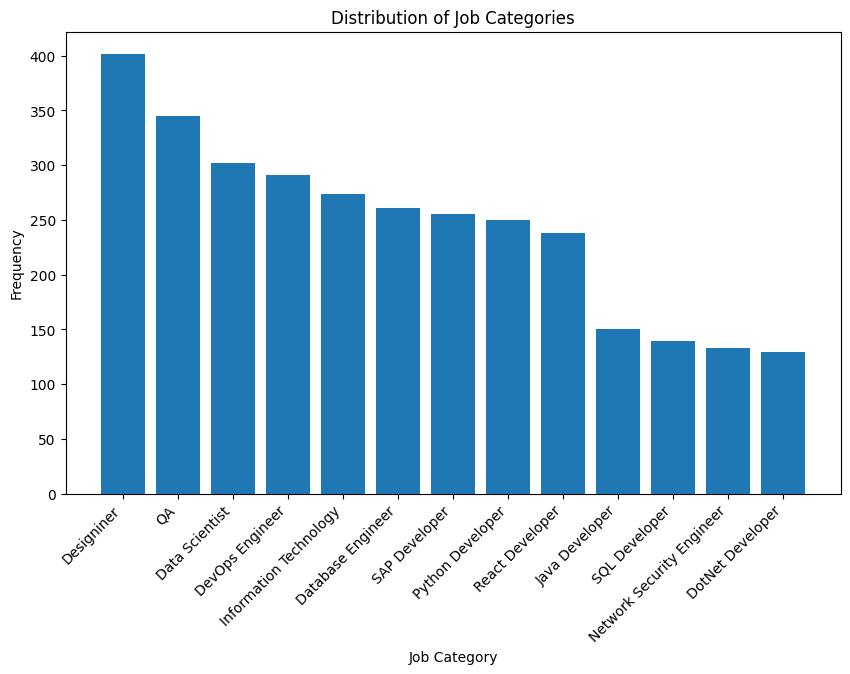

In [ ]:
# @title Distribution of Job Categories

import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
category_counts = data['Category'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel("Job Category")
plt.ylabel("Frequency")
plt.title("Distribution of Job Categories")
_ = plt.xticks(rotation=45, ha='right')

In [ ]:
data=data.dropna()
data = data.drop_duplicates()

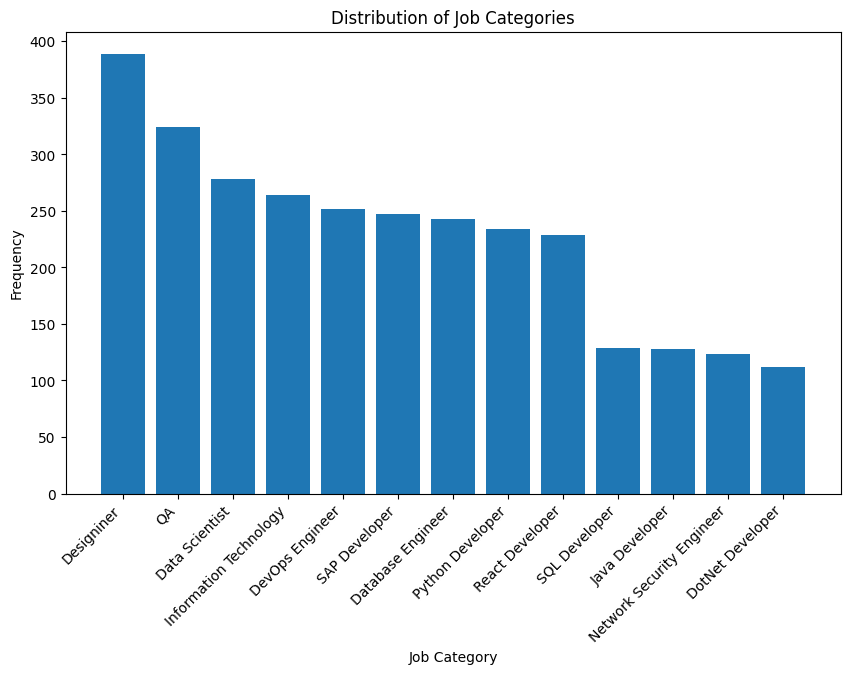

In [ ]:
category_counts = data['Category'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel("Job Category")
plt.ylabel("Frequency")
plt.title("Distribution of Job Categories")
_ = plt.xticks(rotation=45, ha='right')

In [ ]:
texts = data['Extracted Text'].tolist()
labels = data['Category'].tolist()

In [ ]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, encoded_labels, test_size=0.2, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

In [ ]:
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # Number of training steps
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Epoch 2: 100%|██████████| 148/148 [00:51<00:00,  2.89it/s, loss=0.182]


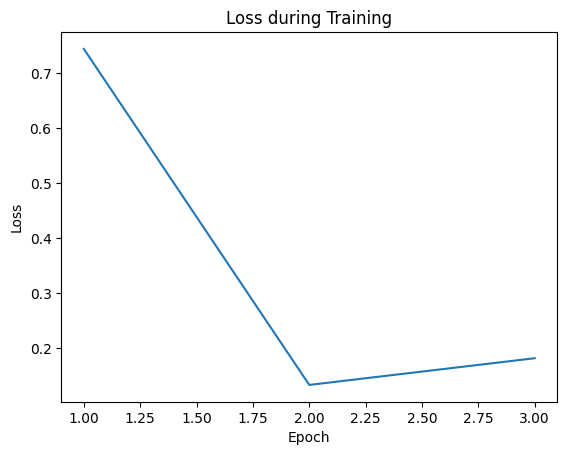

In [ ]:
model.train()
losses=[]
for epoch in range(3):  # Number of epochs
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {key: val.to(device) for key, val in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    losses.append(loss.item())

plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.show()

In [ ]:
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))

                           precision    recall  f1-score   support

           Data Scientist       0.89      0.92      0.90        62
        Database Engineer       0.83      0.86      0.84        56
               Designiner       0.88      0.93      0.90        71
          DevOps Engineer       0.92      0.98      0.95        50
         DotNet Developer       1.00      1.00      1.00        24
   Information Technology       0.89      0.87      0.88        62
           Java Developer       0.90      0.90      0.90        21
Network Security Engineer       0.96      1.00      0.98        27
         Python Developer       0.62      0.79      0.70        39
                       QA       0.89      0.89      0.89        56
          React Developer       0.82      0.49      0.61        55
            SAP Developer       0.96      1.00      0.98        46
            SQL Developer       1.00      0.91      0.95        22

                 accuracy                           0.88    

In [ ]:
model.save_pretrained('/content/drive/MyDrive/ResumeClassifier')
tokenizer.save_pretrained('/content/drive/MyDrive/ResumeClassifier')

('/content/drive/MyDrive/ResumeClassifier/tokenizer_config.json',
 '/content/drive/MyDrive/ResumeClassifier/special_tokens_map.json',
 '/content/drive/MyDrive/ResumeClassifier/vocab.txt',
 '/content/drive/MyDrive/ResumeClassifier/added_tokens.json')

In [ ]:
model_path = '/content/drive/MyDrive/ResumeClassifier'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Example inference
text = "jessica claire resumesampleexamplecom montgomery street san francisco ca qualifications strong analytical skills document management strong collaborative skills optimizing performance tuning excellent problem solving skills customer needs assessment problem analysis resolution process improvements project management quality productivity improvernent strong communication skils troubleshooting training development education training argosy university atlanta ga master arts educational leadership benedict college columbia sc bachelor science biology career overview experienced following computer systems analyst diverse industry experience banking retail business manufacturing business professional expertise includes systems applications data mapping data analysis skills knowledge cics accounts payable system tso audit control data base qmf query management facility vmi vendor management inventory idw industry data warehouse jcl unix dos unix workbench ultra edit clarify sap r dos microsoft dbase ill power point gentran translator gentran mapping platform gis translator gis map editor harbinger translator mapping unix platformtle communication interface environments van beginning visual basic basic programming accomplishments requirements analysis completed business requirements analysis including evaluation systems specifications client ebusiness two weeks ahead deadline quality assurance streamlined qa process increase efficiency reduce processing errors operational management identified recommended prioritized new edi features applications conjunction business leaders department managers developed coded installed tested debugged documented edi applications using appropriate editors network support acted first point contact major technical issues client interface improved client relationships project predictability shared business technical perspectives agreed project roles risk assessment use cases transparent businessaligned development efforts timeboxed delivery work experience netlink communicatons middle school science teacher indianapolis current manage instruct middle high school science courses conduct parent teacher conferences review assessments students professional development collaboration teachers design curriculum lesson plans performing basic administrative duties recording attendance grading assignments organizing student class work daily routines created daily lesson plans aligned state standards formatted objective opening introduction guided practice independent practice closing helping students measure progress learning lesson applied differentiated instruction based individual student learning styles maximized learning opportunities students motivated take control learning established maintained positive relationships students parents colleagues fostering environment open communication support implement cocoordinator student intervention program monitoring assessing student progress oneone basis fisery system analyst city state provide analysis management electronic commerce related projects duties include analyzing electronic commerce needs recommending implementing solutions project management production support responsibilities include creating edi partnerships maps translation tables code list various setups peregrine gis crossreference testing inbound outbound data supported mapped many ed transaction sets sap r environment utilizing idoc functionality work closely tearm members ensure sox compliance trouble shooting responding inquires daily activities performed provide superior customer service"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
outputs = model(**inputs)
predicted_label = torch.argmax(outputs.logits, dim=1).item()
print(f'Predicted Label: {label_encoder.inverse_transform([predicted_label])[0]}')

Predicted Label: Data Scientist
